### Problem: 
    STOCK PRICE ANALYSIS
    Ticker: FTSE (UK Stock Price)
    EXOGENOUS Variables: Additional tickers such as S&P, DAX

### Team members: 
Pramod Krishna,
Praveen Deekonda,
Praveen Kumar,
Hemanth Nair

### Loading Packages

In [19]:
import numpy as np
import pandas as pd
import scipy
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima_model import ARMA, ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
from arch import arch_model
import yfinance
import warnings
warnings.filterwarnings("ignore")
sns.set()

In [4]:
raw_data = yfinance.download(tickers = "^NSEI ^N225 ^GSPC", start = "2000-01-07",
                            end = "2020-06-08", interval = "1d", group_by = 'ticker',
                            auto_adjust = True, treads = True)

[*********************100%***********************]  3 of 3 completed


In [5]:
df_comp = raw_data.copy()

In [6]:
df_comp

^NSEI                                                      \
                    Open          High           Low         Close    Volume   
Date                                                                           
2000-01-06           NaN           NaN           NaN           NaN       NaN   
2000-01-07           NaN           NaN           NaN           NaN       NaN   
2000-01-10           NaN           NaN           NaN           NaN       NaN   
2000-01-11           NaN           NaN           NaN           NaN       NaN   
2000-01-12           NaN           NaN           NaN           NaN       NaN   
...                  ...           ...           ...           ...       ...   
2020-06-01   9726.849609   9931.599609   9706.950195   9826.150391  794200.0   
2020-06-02   9880.849609   9995.599609   9824.049805   9979.099609  770200.0   
2020-06-03  10108.299805  10176.200195  10035.549805  10061.549805  794700.0   
2020-06-04  10054.250000  10123.849609   9944.250000  10029.099609  775100.0   
2020-06-05  10093.799805  10177.799805  10040.750000  10142.150391  987100.0   

                   ^N225                                                     \
                    Open          High           Low         Close   Volume   
Date                                                                          
2000-01-06           NaN           NaN           NaN           NaN      NaN   
2000-01-07  18194.050781  18285.730469  18068.099609  18193.410156      0.0   
2000-01-10           NaN           NaN           NaN           NaN      NaN   
2000-01-11  18246.099609  18887.560547  18246.099609  18850.919922      0.0   
2000-01-12  18780.169922  18811.869141  18626.919922  18677.419922      0.0   
...                  ...           ...           ...           ...      ...   
2020-06-01  21910.890625  22161.390625  21898.990234  22062.390625  72200.0   
2020-06-02  22175.519531  22401.789062  22118.400391  22325.609375  77900.0   
2020-06-03  22649.009766  22818.869141  22462.679688  22613.759766  94100.0   
2020-06-04  22885.140625  22907.919922  22501.810547  22695.740234  92000.0   
2020-06-05  22613.080078  22865.880859  22563.560547  22863.730469  85600.0   

                  ^GSPC                                                       
                   Open         High          Low        Close        Volume  
Date                                                                          
2000-01-06  1402.109985  1411.900024  1392.099976  1403.449951  1.092300e+09  
2000-01-07  1403.449951  1441.469971  1400.729980  1441.469971  1.225200e+09  
2000-01-10  1441.469971  1464.359985  1441.469971  1457.599976  1.064800e+09  
2000-01-11  1457.599976  1458.660034  1434.420044  1438.560059  1.014000e+09  
2000-01-12  1438.560059  1442.599976  1427.079956  1432.250000  9.746000e+08  
...                 ...          ...          ...          ...           ...  
2020-06-01  3038.780029  3062.179932  3031.540039  3055.729980  4.673410e+09  
2020-06-02  3064.780029  3081.070068  3051.639893  3080.820068  5.187230e+09  
2020-06-03  3098.899902  3130.939941  3098.899902  3122.870117  5.989560e+09  
2020-06-04  3111.560059  3128.909912  3090.409912  3112.350098  6.428130e+09  
2020-06-05  3163.840088  3211.719971  3163.840088  3193.929932  8.617590e+09  

[5309 rows x 15 columns]

In [7]:
raw_data = yfinance.download(tickers = "^FTSE ^N225 ^GSPC ^GDAXI", start = "1994-01-07",
                            end = "2020-06-08", interval = "1d", group_by = 'ticker',
                            auto_adjust = True, treads = True)

[*********************100%***********************]  4 of 4 completed


In [8]:
df_comp =raw_data.copy()

In [9]:
df_comp['spx'] = df_comp['^GSPC'].Close[:]
df_comp['dax'] = df_comp['^GDAXI'].Close[:]
df_comp['nikkei'] = df_comp['^N225'].Close[:]
df_comp['ftse'] = df_comp['^FTSE'].Close[:]

In [10]:
df_comp = df_comp.iloc[1:]
del df_comp['^N225']
del df_comp['^GDAXI']
del df_comp['^GSPC']
del df_comp['^FTSE']
df_comp = df_comp.asfreq('b')
df_comp =df_comp.fillna(method = 'ffill')

### Creating Returns

In [11]:
df_comp['ret_spx'] = df_comp.spx.pct_change(1)*100
df_comp['ret_ftse'] = df_comp.ftse.pct_change(1)*100
df_comp['ret_dax'] = df_comp.dax.pct_change(1)*100
df_comp['ret_nikkei'] = df_comp.nikkei.pct_change(1)*100

### Normalising Returns

In [12]:
df_comp['norm_ret_spx'] = df_comp.ret_spx.div(df_comp.ret_spx[1])*100
df_comp['norm_ret_ftse'] = df_comp.ret_ftse.div(df_comp.ret_ftse[1])*100
df_comp['norm_ret_dax'] = df_comp.ret_dax.div(df_comp.ret_dax[1])*100
df_comp['norm_ret_nikkei'] = df_comp.ret_nikkei.div(df_comp.ret_nikkei[1])*100

### Splitting the data

In [14]:
size = int(len(df_comp)*0.8)
df, df_test = df_comp.iloc[:size], df_comp.iloc[size:]

### Fitting a Model

In [20]:
model_ar = ARIMA(df.ftse, order =(1,0,0))
result_ar = model_ar.fit()

### Simple Forecasting

In [17]:
df.ftse.tail()

Date
2015-02-17    6898.100098
2015-02-18    6898.100098
2015-02-19    6888.899902
2015-02-20    6915.200195
2015-02-23    6912.200195
Freq: B, Name: ftse, dtype: float64

In [62]:
start_date = "2015-02-24"
end_date = "2015-08-03"

In [63]:
df_pred = result_ar.predict(start = start_date, end = end_date)

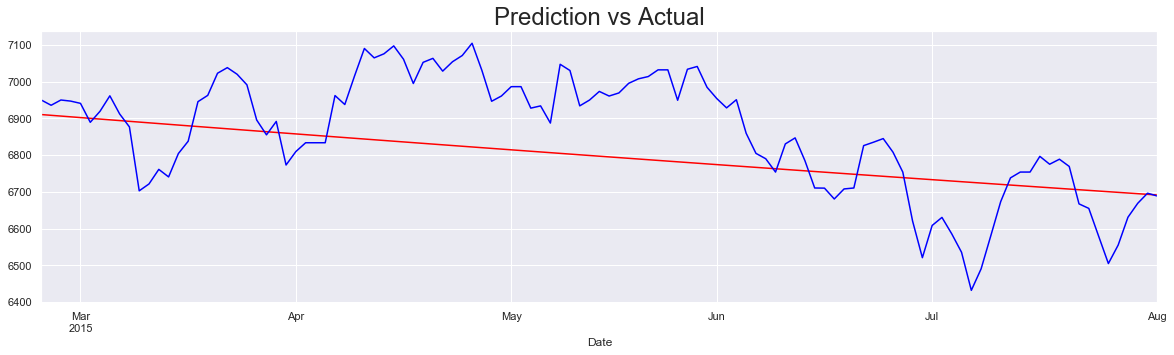

In [64]:
df_pred[start_date:end_date].plot(figsize = (20,5), color = 'red')
df_test.ftse[start_date:end_date].plot(color = 'blue')
plt.title("Prediction vs Actual", size =24)
plt.show()

The constant decline is due to the choice of our model.
The Predictions are only based on the constant and the prices from the previous period.
Sellers often have an incentive to sell, while buyers tend to wait before buying. Which is why the AR model simply shows a diminishing curve.

### Using Returns

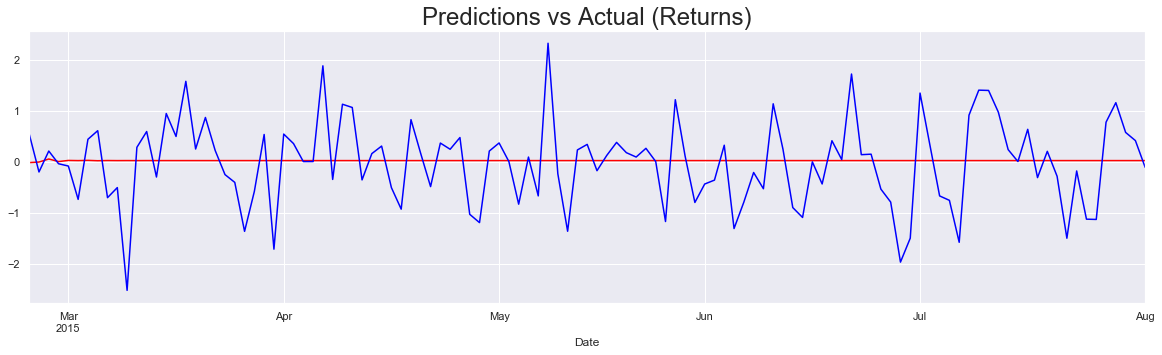

In [35]:
model_ret_ar = ARIMA(df.ret_ftse[1:], order = (5,0,0))
results_ret_ar = model_ret_ar.fit()

df_pred_ar = results_ret_ar.predict(start = start_date, end = end_date) 

df_pred_ar[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.ret_ftse[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual (Returns)", size = 24)
plt.show()

In [36]:
results_ret_ar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:               ret_ftse   No. Observations:                 5511
Model:                     ARMA(5, 0)   Log Likelihood               -8520.199
Method:                       css-mle   S.D. of innovations              1.136
Date:                Thu, 11 Jun 2020   AIC                          17054.399
Time:                        10:16:16   BIC                          17100.700
Sample:                    01-10-1994   HQIC                         17070.547
                         - 02-23-2015                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0192      0.013      1.464      0.143      -0.007       0.045
ar.L1.ret_ftse    -0.0217      0.013     -1.612      0.107      -0.048       0.005
ar.L2.ret_ftse    -0.0529      0.013     -3.933      0.000      -0.079      -0.027
ar.L3.ret_ftse    -0.0766      0.013     -5.711      0.000      -0.103      -0.050
ar.L4.ret_ftse     0.0410      0.013      3.050      0.002       0.015       0.067
ar.L5.ret_ftse    -0.0567      0.013     -4.219      0.000      -0.083      -0.030
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.5734           -0.0000j            1.5734           -0.5000
AR.2           -0.3015           -1.7403j            1.7662           -0.2773
AR.3           -0.3015           +1.7403j            1.7662            0.2773
AR.4            1.4494           -1.2209j            1.8951           -0.1114
AR.5            1.4494           +1.2209j            1.8951            0.1114
-----------------------------------------------------------------------------
"""

### MA

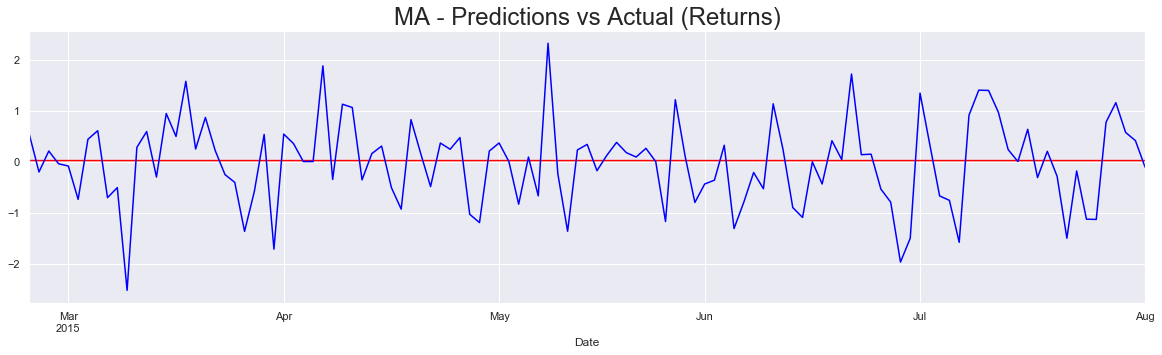

In [40]:
model_ret_ma = ARIMA(df.ret_ftse[1:], order=(0,0,1))
results_ret_ma = model_ret_ma.fit()

df_pred_ma = results_ret_ma.predict(start = start_date, end = end_date) 

df_pred_ma[start_date:end_date].plot(figsize = (20,5), color = "red")   
df_test.ret_ftse[start_date:end_date].plot(color = "blue")
plt.title("MA - Predictions vs Actual (Returns)", size = 24)
plt.show()

In [39]:
df_pred_ma.head()

2015-02-24    0.020513
2015-02-25    0.019171
2015-02-26    0.019171
2015-02-27    0.019171
2015-03-02    0.019171
Freq: B, dtype: float64

### ARMA

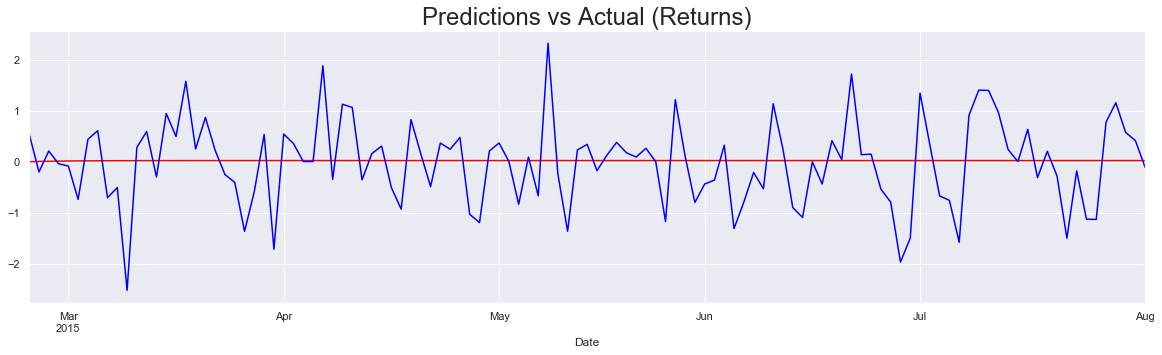

In [41]:
model_ret_arma = ARIMA(df.ret_ftse[1:], order=(1,0,1))
results_ret_arma = model_ret_arma.fit()

df_pred_arma = results_ret_arma.predict(start = start_date, end = end_date)

df_pred_arma[start_date:end_date].plot(figsize = (20,5), color = "red")   
df_test.ret_ftse[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual (Returns)", size = 24)
plt.show()

In [43]:
df_pred_arma.head()

2015-02-24   -0.004061
2015-02-25    0.001098
2015-02-26    0.005112
2015-02-27    0.008236
2015-03-02    0.010666
Freq: B, dtype: float64

In [44]:
df_pred_arma.tail()

2015-07-28    0.019182
2015-07-29    0.019182
2015-07-30    0.019182
2015-07-31    0.019182
2015-08-03    0.019182
Freq: B, dtype: float64

### ARMAX

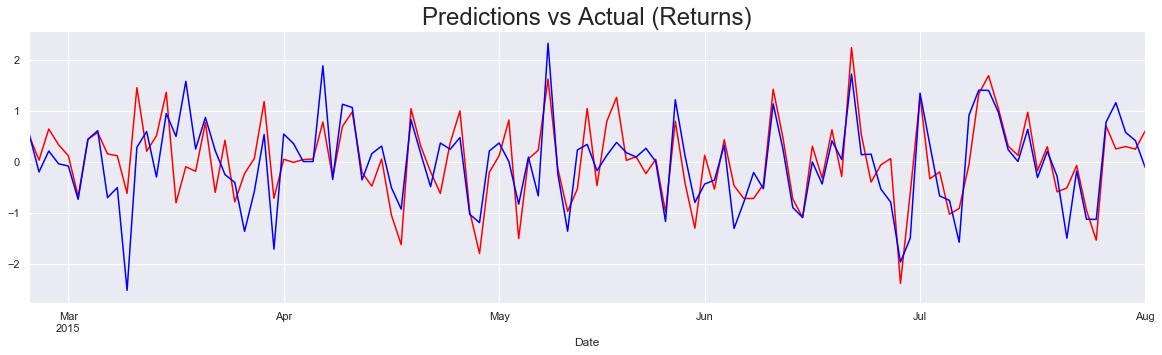

In [46]:
model_ret_armax = ARIMA(df.ret_ftse[1:], exog = df[["ret_spx","ret_dax","ret_nikkei"]][1:], order = (1,0,1))
results_ret_armax = model_ret_armax.fit()

df_pred_armax = results_ret_armax.predict(start = start_date, end = end_date, 
                                          exog = df_test[["ret_spx","ret_dax","ret_nikkei"]][start_date:end_date]) 

df_pred_armax[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.ret_ftse[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual (Returns)", size = 24)
plt.show()

In [78]:
results_ret_armax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:               ret_ftse   No. Observations:                 5511
Model:                     ARMA(1, 1)   Log Likelihood               -5688.394
Method:                       css-mle   S.D. of innovations              0.679
Date:                Thu, 11 Jun 2020   AIC                          11390.788
Time:                        12:29:14   BIC                          11437.089
Sample:                    01-10-1994   HQIC                         11406.936
                         - 02-23-2015                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.0071      0.007     -0.973      0.330      -0.022       0.007
ret_spx            0.1075      0.010     10.760      0.000       0.088       0.127
ret_dax            0.5472      0.008     67.599      0.000       0.531       0.563
ret_nikkei         0.0738      0.006     11.409      0.000       0.061       0.087
ar.L1.ret_ftse     0.4045      0.099      4.093      0.000       0.211       0.598
ma.L1.ret_ftse    -0.5229      0.092     -5.674      0.000      -0.703      -0.342
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.4722           +0.0000j            2.4722            0.0000
MA.1            1.9126           +0.0000j            1.9126            0.0000
-----------------------------------------------------------------------------
"""

### SARMA

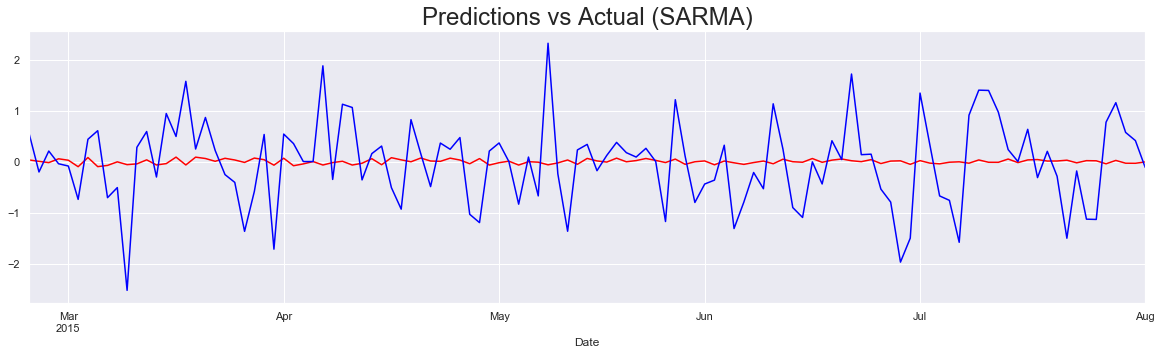

In [48]:
model_ret_sarma = SARIMAX(df.ret_ftse[1:], order = (3,0,4), seasonal_order = (3,0,2,5))
results_ret_sarma = model_ret_sarma.fit()

df_pred_sarma = results_ret_sarma.predict(start = start_date, end = end_date)

df_pred_sarma[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.ret_ftse[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual (SARMA)", size = 24)
plt.show()

### SARIMAX

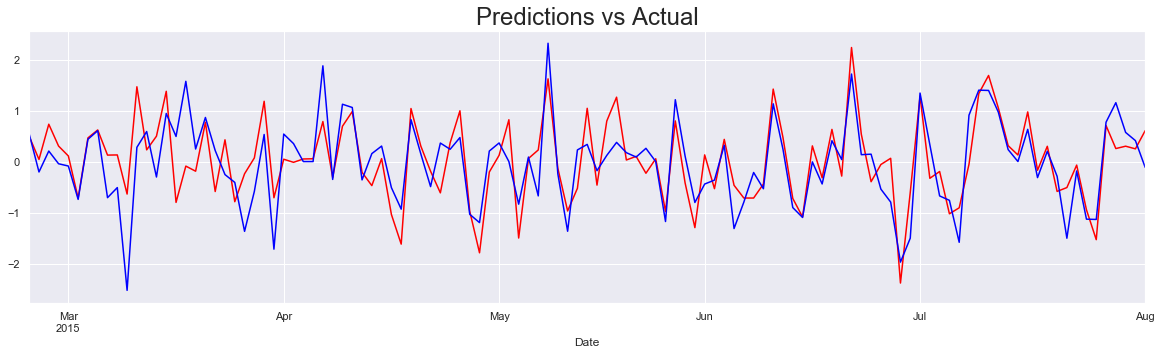

In [49]:
model_ret_sarimax = SARIMAX(df.ret_ftse[1:], exog = df[["ret_spx","ret_dax","ret_nikkei"]][1:], 
                            order = (3,0,4), seasonal_order = (3,0,2,5))
results_ret_sarimax = model_ret_sarimax.fit()

df_pred_sarimax = results_ret_sarimax.predict(start = start_date, end = end_date, 
                                              exog = df_test[["ret_spx","ret_dax","ret_nikkei"]][start_date:end_date]) 

df_pred_sarimax[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.ret_ftse[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual", size = 24)
plt.show()

In [77]:
results_ret_sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                          ret_ftse   No. Observations:                 5511
Model:             SARIMAX(3, 0, 4)x(3, 0, 2, 5)   Log Likelihood               -5666.209
Date:                           Thu, 11 Jun 2020   AIC                          11364.418
Time:                                   12:28:33   BIC                          11470.250
Sample:                               01-10-1994   HQIC                         11401.328
                                    - 02-23-2015                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ret_spx        0.1083      0.006     17.986      0.000       0.097       0.120
ret_dax        0.5454      0.005    104.410      0.000       0.535       0.556
ret_nikkei     0.0745      0.005     15.805      0.000       0.065       0.084
ar.L1          1.0067      0.202      4.976      0.000       0.610       1.403
ar.L2         -0.0317      0.447     -0.071      0.944      -0.908       0.845
ar.L3         -0.1531      0.339     -0.451      0.652      -0.818       0.512
ma.L1         -1.1307      0.202     -5.607      0.000      -1.526      -0.735
ma.L2          0.1479      0.468      0.316      0.752      -0.769       1.065
ma.L3          0.0946      0.391      0.242      0.809      -0.672       0.861
ma.L4          0.0457      0.048      0.952      0.341      -0.048       0.140
ar.S.L5        0.8669      0.547      1.585      0.113      -0.205       1.939
ar.S.L10      -0.3790      0.255     -1.485      0.137      -0.879       0.121
ar.S.L15      -0.0013      0.032     -0.041      0.967      -0.063       0.061
ma.S.L5       -0.9060      0.547     -1.657      0.098      -1.978       0.166
ma.S.L10       0.3594      0.276      1.304      0.192      -0.181       0.900
sigma2         0.4576      0.005     90.338      0.000       0.448       0.468
===================================================================================
Ljung-Box (Q):                       47.80   Jarque-Bera (JB):             11945.62
Prob(Q):                              0.19   Prob(JB):                         0.00
Heteroskedasticity (H):               0.90   Skew:                             0.22
Prob(H) (two-sided):                  0.02   Kurtosis:                        10.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [50]:
model_auto = auto_arima(df.ret_ftse[1:], 
                        exogenous = df[['ret_spx', 'ret_dax', 'ret_nikkei']][1:],
                        m = 5, 
                        max_p = 5, 
                        max_q = 5, 
                        max_P = 5, 
                        max_Q = 5)

In [65]:
model_auto

ARIMA(callback=None, disp=0, maxiter=None, method=None, order=(3, 0, 0),
      out_of_sample_size=0, scoring='mse', scoring_args={},
      seasonal_order=(2, 0, 1, 5), solver='lbfgs', start_params=None,
      suppress_warnings=False, transparams=True, trend=None,
      with_intercept=True)

In [51]:
df_auto_pred = pd.DataFrame(model_auto.predict(n_periods = len(df_test[start_date:end_date]),
                            exogenous = df_test[['ret_spx', 'ret_dax', 'ret_nikkei']][start_date:end_date]),
                            index = df_test[start_date:end_date].index)

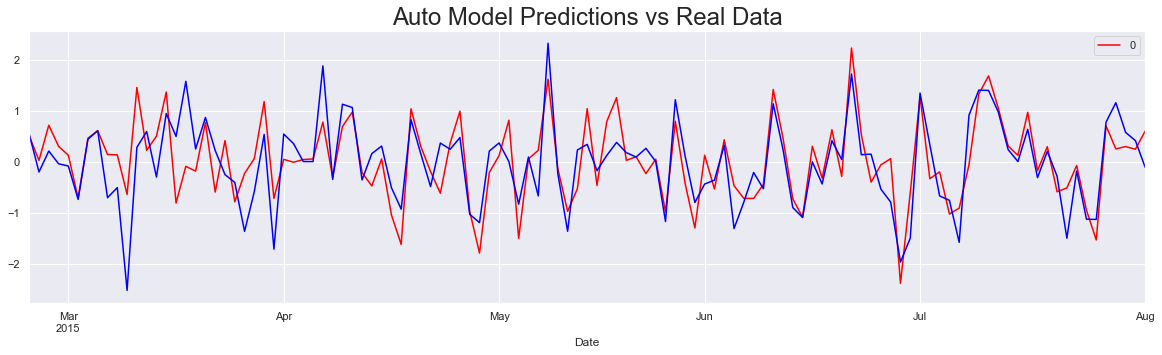

In [52]:
df_auto_pred.plot(figsize = (20,5), color = "red")
df_test.ret_ftse[start_date:end_date].plot(color = "blue")
plt.title("Auto Model Predictions vs Real Data", size = 24)
plt.show()

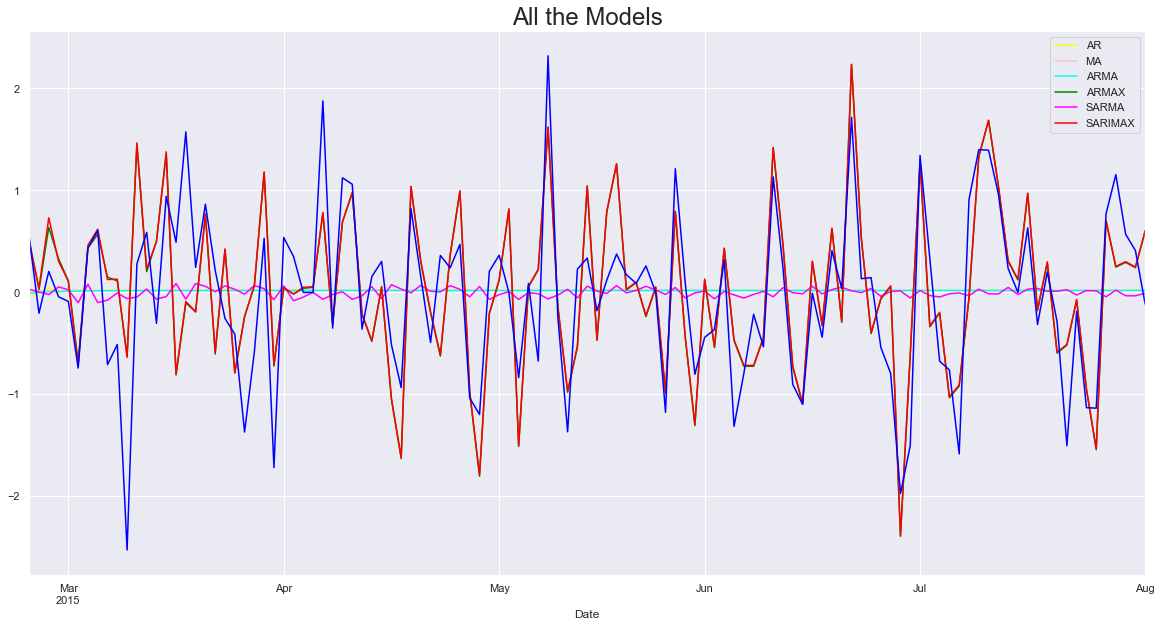

In [53]:
df_pred_ar[start_date:end_date].plot(figsize = (20,10), color = "yellow")
df_pred_ma[start_date:end_date].plot(color = "pink")
df_pred_arma[start_date:end_date].plot(color = "cyan")
df_pred_armax[start_date:end_date].plot(color = "green")
df_pred_sarma[start_date:end_date].plot(color = "magenta")
df_pred_sarimax[start_date:end_date].plot(color = "red")
df_test.ret_ftse[start_date:end_date].plot(color = "blue")
plt.legend(['AR','MA','ARMA','ARMAX','SARMA','SARIMAX'])
plt.title("All the Models", size = 24)
plt.show()

### Forecasting Volatility with GARCH model

In [54]:
mod_garch = arch_model(df_comp.ret_ftse[1:], vol = "GARCH", p = 1, q = 1, mean = "constant", dist = "Normal")
res_garch = mod_garch.fit(last_obs = start_date, update_freq = 10)

Iteration:     10,   Func. Count:     73,   Neg. LLF: 7498.446722101243
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 7498.425418702819
            Iterations: 13
            Function evaluations: 91
            Gradient evaluations: 13


In [67]:
pred_garch = res_garch.forecast(horizon = 1, align = 'target')

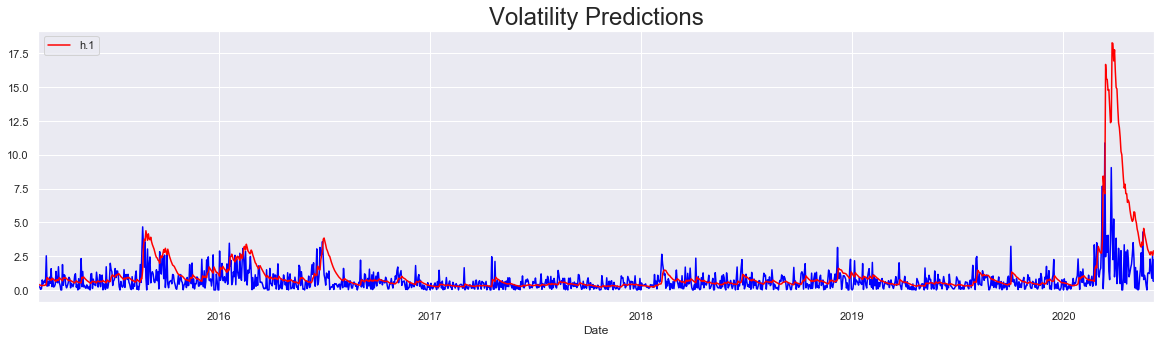

In [69]:
pred_garch.residual_variance[start_date:].plot(figsize = (20,5), color = "red", zorder = 2)
df_test.ret_ftse.abs().plot(color = "blue", zorder = 1)
plt.title("Volatility Predictions", size = 24)
plt.show()

In [79]:
pred_garch = res_garch.forecast(horizon = 30, align = 'target')
pred_garch.residual_variance[-1:]

,h.01,h.02,h.03,h.04,h.05,h.06,h.07,h.08,h.09,h.10,...,h.21,h.22,h.23,h.24,h.25,h.26,h.27,h.28,h.29,h.30
Date,,,,,,,,,,,,,,,,,,,,,
2020-06-05,2.674627,2.882588,2.540625,2.714886,2.779495,2.54435,2.656085,2.768146,2.894714,3.159467,...,3.799047,3.991415,4.348046,4.533215,4.936219,4.943139,4.429147,4.317098,4.438458,4.641145


### Multivariate Regression Model

In [71]:
from statsmodels.tsa.api import VAR

In [72]:
df_ret = df[['ret_spx', 'ret_dax', 'ret_ftse', 'ret_nikkei']][1:]

In [73]:
model_var_ret = VAR(df_ret)
model_var_ret.select_order(20)
results_var_ret = model_var_ret.fit(ic = 'aic')

In [74]:
results_var_ret.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 11, Jun, 2020
Time:                     12:06:16
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   0.280733
Nobs:                     5506.00    HQIC:                  0.215026
Log likelihood:          -31661.8    FPE:                    1.19702
AIC:                     0.179835    Det(Omega_mle):         1.17893
--------------------------------------------------------------------
Results for equation ret_spx
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                 0.039382         0.015799            2.493           0.013
L1.ret_spx           -0.110073         0.017281           -6.370           0.000
L1.ret_dax            0.062864         0.018686           